In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 특정 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7500)])
    except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)
        
print('GPU ready')

GPU ready


In [2]:
import pandas as pd

category_csv = pd.read_csv('./category/category.csv', encoding='CP949')
label_dict = dict(category_csv[['bottle_name', 'bottle_id']].values)
print(label_dict)

{'wine': 0, 'soju': 1, 'plate': 2, 'me': 3, 'glass': 4, 'energydrink': 5, 'case': 6, 'bottle': 7, 'be': 8}


Found 100 images belonging to 9 classes.
Found 20 images belonging to 9 classes.


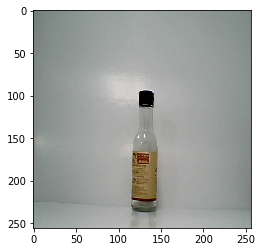

In [6]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt


rootPath = './image_data/촬영본'

with tf.device('/device:GPU:0'):

    train_imageGenerator = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
#         zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=.2
    )
    
    val_imageGenerator = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
    )
    
    trainGen = train_imageGenerator.flow_from_directory(
        rootPath,
        target_size=(256, 256),
        classes=label_dict,
        subset='training',
        batch_size = 100,
        class_mode="sparse"
    )

    validationGen = val_imageGenerator.flow_from_directory(
        rootPath,
        target_size=(256, 256),
        classes=label_dict,
        subset='validation',
        batch_size = 20,
        class_mode="sparse"
    )

    
    x_train, y_train = validationGen.next()
    plt.imshow(x_train[0])
    plt.show()


In [12]:
import tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, InputLayer,ZeroPadding2D
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, InputLayer
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



with tf.device('/device:GPU:0'):

    model = Sequential()
    model.add(InputLayer(input_shape=(256,256,3)))
    
    model.add(ZeroPadding2D(padding=(2, 2)))
    model.add(Conv2D(96, 
                     kernel_size = (11,11), 
                     strides=4, 
                     ))

    model.add(MaxPooling2D(pool_size=(3, 3)))
    
    
    model.add(ZeroPadding2D(padding=(2, 2)))
    model.add(Conv2D(192, 
                     kernel_size = (5,5), 
                     strides=1,))

    model.add(MaxPooling2D(pool_size=(3, 3)))

    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(Conv2D(288, 
                     kernel_size = (3,3), 
                     strides=1))
    
    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(Conv2D(288, 
                     kernel_size = (3,3), 
                     strides=1,
                     ))

    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(Conv2D(192, 
                     kernel_size = (3,3), 
                     strides=1,))

    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    model.add(Flatten(input_shape=(3*3*192,)))
    
    model.add(Dense(4096, activation='relu'))

    model.add(Dense(4096, activation='relu'))
    
    model.add(Dense(9, activation='softmax'))

    model.summary()

    model.compile(optimizer=RMSprop(learning_rate=1e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    # Model saving callback
    checkpointer = ModelCheckpoint(filepath='./model/recycle_Tung_Yang.h5', monitor='val_loss', verbose=1, save_best_only=True)

#     Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=10)

    epochs = 500
    history = model.fit_generator(
        trainGen, 
        epochs=epochs,
        callbacks=[checkpointer, early_stopping],
        steps_per_epoch=1, 
        validation_data=validationGen,
        validation_steps=1,
        verbose=1
    )







Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_10 (ZeroPaddi (None, 260, 260, 3)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 63, 63, 96)        34944     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 21, 21, 96)        0         
_________________________________________________________________
zero_padding2d_11 (ZeroPaddi (None, 25, 25, 96)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 21, 21, 192)       460992    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 192)         0         
_________________________________________________________________
zero_padding2d_12 (ZeroPaddi (None, 9, 9, 192)        

Epoch 16/500
1/1 [==============================] - ETA: 0s - loss: 1.9504 - sparse_categorical_accuracy: 0.2200
Epoch 00016: val_loss improved from 1.90094 to 1.88604, saving model to ./model/recycle_Tung_Yang.h5
1/1 [==============================] - 1s 717ms/step - loss: 1.9504 - sparse_categorical_accuracy: 0.2200 - val_loss: 1.8860 - val_sparse_categorical_accuracy: 0.3500
Epoch 17/500
1/1 [==============================] - ETA: 0s - loss: 1.9447 - sparse_categorical_accuracy: 0.2500
Epoch 00017: val_loss improved from 1.88604 to 1.87617, saving model to ./model/recycle_Tung_Yang.h5
1/1 [==============================] - 1s 743ms/step - loss: 1.9447 - sparse_categorical_accuracy: 0.2500 - val_loss: 1.8762 - val_sparse_categorical_accuracy: 0.1500
Epoch 18/500
1/1 [==============================] - ETA: 0s - loss: 1.9373 - sparse_categorical_accuracy: 0.2100
Epoch 00018: val_loss improved from 1.87617 to 1.85540, saving model to ./model/recycle_Tung_Yang.h5
1/1 [===================

1/1 [==============================] - 1s 711ms/step - loss: 1.7154 - sparse_categorical_accuracy: 0.3300 - val_loss: 1.5745 - val_sparse_categorical_accuracy: 0.6500
Epoch 39/500
1/1 [==============================] - ETA: 0s - loss: 1.6979 - sparse_categorical_accuracy: 0.4100
Epoch 00039: val_loss did not improve from 1.57446
1/1 [==============================] - 0s 118ms/step - loss: 1.6979 - sparse_categorical_accuracy: 0.4100 - val_loss: 1.5972 - val_sparse_categorical_accuracy: 0.3000
Epoch 40/500
1/1 [==============================] - ETA: 0s - loss: 1.6839 - sparse_categorical_accuracy: 0.3200
Epoch 00040: val_loss improved from 1.57446 to 1.55057, saving model to ./model/recycle_Tung_Yang.h5
1/1 [==============================] - 1s 710ms/step - loss: 1.6839 - sparse_categorical_accuracy: 0.3200 - val_loss: 1.5506 - val_sparse_categorical_accuracy: 0.6500
Epoch 41/500
1/1 [==============================] - ETA: 0s - loss: 1.6791 - sparse_categorical_accuracy: 0.4700
Epoch 00

Epoch 62/500
1/1 [==============================] - ETA: 0s - loss: 1.4825 - sparse_categorical_accuracy: 0.4200
Epoch 00062: val_loss improved from 1.31094 to 1.28174, saving model to ./model/recycle_Tung_Yang.h5
1/1 [==============================] - 1s 715ms/step - loss: 1.4825 - sparse_categorical_accuracy: 0.4200 - val_loss: 1.2817 - val_sparse_categorical_accuracy: 0.8000
Epoch 63/500
1/1 [==============================] - ETA: 0s - loss: 1.4566 - sparse_categorical_accuracy: 0.5100
Epoch 00063: val_loss did not improve from 1.28174
1/1 [==============================] - 0s 118ms/step - loss: 1.4566 - sparse_categorical_accuracy: 0.5100 - val_loss: 1.3720 - val_sparse_categorical_accuracy: 0.3500
Epoch 64/500
1/1 [==============================] - ETA: 0s - loss: 1.4600 - sparse_categorical_accuracy: 0.4300
Epoch 00064: val_loss improved from 1.28174 to 1.25510, saving model to ./model/recycle_Tung_Yang.h5
1/1 [==============================] - 1s 698ms/step - loss: 1.4600 - spar

1/1 [==============================] - ETA: 0s - loss: 1.2801 - sparse_categorical_accuracy: 0.5700
Epoch 00085: val_loss did not improve from 1.09402
1/1 [==============================] - 0s 118ms/step - loss: 1.2801 - sparse_categorical_accuracy: 0.5700 - val_loss: 1.1032 - val_sparse_categorical_accuracy: 0.8000
Epoch 86/500
1/1 [==============================] - ETA: 0s - loss: 1.2524 - sparse_categorical_accuracy: 0.5800
Epoch 00086: val_loss improved from 1.09402 to 1.06231, saving model to ./model/recycle_Tung_Yang.h5
1/1 [==============================] - 1s 711ms/step - loss: 1.2524 - sparse_categorical_accuracy: 0.5800 - val_loss: 1.0623 - val_sparse_categorical_accuracy: 0.8000
Epoch 87/500
1/1 [==============================] - ETA: 0s - loss: 1.2802 - sparse_categorical_accuracy: 0.5300
Epoch 00087: val_loss did not improve from 1.06231
1/1 [==============================] - 0s 123ms/step - loss: 1.2802 - sparse_categorical_accuracy: 0.5300 - val_loss: 1.1621 - val_sparse

1/1 [==============================] - 1s 714ms/step - loss: 1.2823 - sparse_categorical_accuracy: 0.5100 - val_loss: 0.9335 - val_sparse_categorical_accuracy: 0.8000
Epoch 109/500
1/1 [==============================] - ETA: 0s - loss: 1.2762 - sparse_categorical_accuracy: 0.5100
Epoch 00109: val_loss did not improve from 0.93347
1/1 [==============================] - 0s 123ms/step - loss: 1.2762 - sparse_categorical_accuracy: 0.5100 - val_loss: 1.1257 - val_sparse_categorical_accuracy: 0.4500
Epoch 110/500
1/1 [==============================] - ETA: 0s - loss: 1.2102 - sparse_categorical_accuracy: 0.5500
Epoch 00110: val_loss improved from 0.93347 to 0.91483, saving model to ./model/recycle_Tung_Yang.h5
1/1 [==============================] - 1s 733ms/step - loss: 1.2102 - sparse_categorical_accuracy: 0.5500 - val_loss: 0.9148 - val_sparse_categorical_accuracy: 0.8000
Epoch 111/500
1/1 [==============================] - ETA: 0s - loss: 1.1957 - sparse_categorical_accuracy: 0.5200
Epoch

1/1 [==============================] - ETA: 0s - loss: 1.1547 - sparse_categorical_accuracy: 0.6000
Epoch 00132: val_loss did not improve from 0.82429
1/1 [==============================] - 0s 123ms/step - loss: 1.1547 - sparse_categorical_accuracy: 0.6000 - val_loss: 1.0581 - val_sparse_categorical_accuracy: 0.5500
Epoch 133/500
1/1 [==============================] - ETA: 0s - loss: 1.1623 - sparse_categorical_accuracy: 0.5300
Epoch 00133: val_loss improved from 0.82429 to 0.81232, saving model to ./model/recycle_Tung_Yang.h5
1/1 [==============================] - 1s 707ms/step - loss: 1.1623 - sparse_categorical_accuracy: 0.5300 - val_loss: 0.8123 - val_sparse_categorical_accuracy: 0.8000
Epoch 134/500
1/1 [==============================] - ETA: 0s - loss: 1.0999 - sparse_categorical_accuracy: 0.5900
Epoch 00134: val_loss did not improve from 0.81232
1/1 [==============================] - 0s 119ms/step - loss: 1.0999 - sparse_categorical_accuracy: 0.5900 - val_loss: 0.9585 - val_spar

Epoch 156/500
1/1 [==============================] - ETA: 0s - loss: 1.0546 - sparse_categorical_accuracy: 0.5800
Epoch 00156: val_loss improved from 0.74752 to 0.74117, saving model to ./model/recycle_Tung_Yang.h5
1/1 [==============================] - 1s 724ms/step - loss: 1.0546 - sparse_categorical_accuracy: 0.5800 - val_loss: 0.7412 - val_sparse_categorical_accuracy: 0.8000
Epoch 157/500
1/1 [==============================] - ETA: 0s - loss: 0.9573 - sparse_categorical_accuracy: 0.6900
Epoch 00157: val_loss did not improve from 0.74117
1/1 [==============================] - 0s 121ms/step - loss: 0.9573 - sparse_categorical_accuracy: 0.6900 - val_loss: 0.8293 - val_sparse_categorical_accuracy: 0.8000
Epoch 158/500
1/1 [==============================] - ETA: 0s - loss: 0.9809 - sparse_categorical_accuracy: 0.6300
Epoch 00158: val_loss did not improve from 0.74117
1/1 [==============================] - 0s 118ms/step - loss: 0.9809 - sparse_categorical_accuracy: 0.6300 - val_loss: 0.7

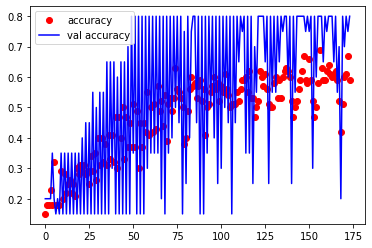

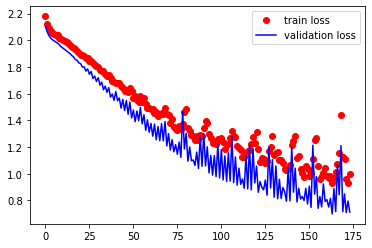

In [13]:

import matplotlib.pyplot as plt

train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

plt.plot(train_acc,'bo', color='r', label='accuracy')
plt.plot(val_acc,'b', color='b', label='val accuracy')
plt.legend()
plt.show()


train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss,'bo', color='r', label='train loss')
plt.plot(val_loss,'b', color='b', label='validation loss')
plt.legend()
plt.show()

[7. 2. 1. 1. 3. 0. 6. 7. 1. 0. 7. 7. 5. 8. 4. 5. 0. 5. 1. 4.]
Confusion Matrix
[7 4 1 1 4 0 4 7 1 0 7 7 5 7 4 5 0 5 1 4]


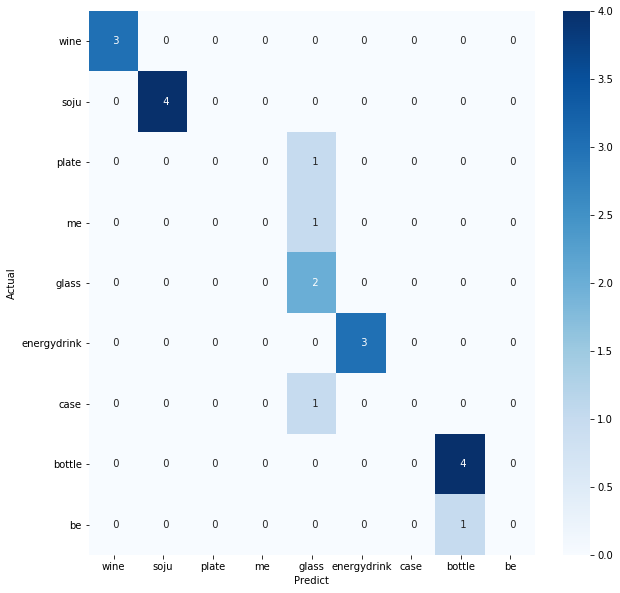

In [17]:
#### from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns 
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model_path = './model/recycle_Tung_Yang.h5'


vgg_model = tf.keras.models.load_model(model_path)


x_train, y_train= validationGen.next()
print(y_train)

#Confution Matrix and Classification Report
Y_pred = vgg_model.predict_generator(validationGen, 1)

y_pred = np.argmax(Y_pred, axis=1)


print('Confusion Matrix')
# display(confusion_matrix(validationGen.classes, y_pred))



print(y_pred)





fig, ax = plt.subplots(figsize=(10,10))  # inch단위로 그림의 크기
sns.heatmap(
    confusion_matrix(y_train, y_pred),
    annot = True, # 숫자표현
    cbar = True,  # color bar 
    fmt = '3d',    # 정수표현     
    cmap = 'Blues', # color 색상
    ax = ax,       # 그래프로 사용할 subplot
    xticklabels=category_csv['bottle_name'], 
    yticklabels=category_csv['bottle_name']
)
ax.set_xlabel('Predict')
ax.set_ylabel('Actual')
plt.show()


# seaborn.heatmap(data, *, vmin=None, vmax=None, cmap=None, center=None, robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels='auto', yticklabels='auto', mask=None, ax=None, **kwargs)
